# Building the stochastic timetables

### Creating Spark Session

In [32]:
import os
%load_ext sparkmagic.magics
from datetime import datetime
username = os.environ['RENKU_USERNAME']
server = server = "http://iccluster029.iccluster.epfl.ch:8998"
from IPython import get_ipython
get_ipython().run_cell_magic('spark', line="config", 
                             cell="""{{ "name":"{0}-final_project", "executorMemory":"4G", "executorCores":4, "numExecutors":10 }}""".format(username))



The sparkmagic.magics extension is already loaded. To reload it, use:
  %reload_ext sparkmagic.magics


In [33]:
get_ipython().run_line_magic(
    "spark", "add -s {0}-final_project -l python -u {1} -k".format(username, server)
)

In [34]:
%%spark
## SPARK IMPORTS
from functools import reduce
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import *

REMOTE_PATH = "/group/abiskop1/project_data/"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
%%spark
real_time = spark.read.orc("/data/sbb/part_orc/istdaten").dropna()

arrivals = spark.read.csv(REMOTE_PATH + "arrivalsRouteStops.csv", header='true', inferSchema='true')
arrivals = arrivals.withColumn("route_id", udf(lambda end_id : end_id.split("$")[0])(col("end_route_stop_id")))

print("The Schema is :")
real_time

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The Schema is :
DataFrame[betriebstag: string, fahrt_bezeichner: string, betreiber_id: string, betreiber_abk: string, betreiber_name: string, produkt_id: string, linien_id: string, linien_text: string, umlauf_id: string, verkehrsmittel_text: string, zusatzfahrt_tf: string, faellt_aus_tf: string, bpuic: string, haltestellen_name: string, ankunftszeit: string, an_prognose: string, an_prognose_status: string, abfahrtszeit: string, ab_prognose: string, ab_prognose_status: string, durchfahrt_tf: string, year: int, month: int]

As I don't speak german :

In [54]:
%%spark
mapping =    [['BETRIEBSTAG', 'date'],
    ['FAHRT_BEZEICHNER', "trip_id"],
    ['BETREIBER_ABK', 'operator'],
    ["BETREIBER_NAME", "operator_name"],
    ["PRODUCT_ID", "type_transport"],
    ["LINIEN_ID"," for trains, this is the train number"],
    ["LINIEN_TEXT","type_service_1"], 
    ["VERKEHRSMITTEL_TEXT","type_service_2"],
    ["ZUSATZFAHRT_TF","additional_trip"],
    ["FAELLT_AUS_TF","trip_failed"],
    ["HALTESTELLEN_NAME","STOP_NAME"],
    ["ANKUNFTSZEIT","arrival_time_schedule"],
    ["AN_PROGNOSE","arrival_time_actual"],
    ["AN_PROGNOSE_STATUS","measure_method_arrival"],
    ["ABFAHRTSZEIT","departure_time_schedule"],
    ["AB_PROGNOSE","departure_time_actual"],
    ["AB_PROGNOSE_STATUS","measure_method_arrival"],
    ["DURCHFAHRT_TF","does_stop_here"]]


for de_name, en_name in mapping:
    real_time = real_time.withColumnRenamed(de_name, en_name)
    
print("Final Schema :")
real_time

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Final Schema :
DataFrame[date: string, trip_id: string, betreiber_id: string, operator: string, operator_name: string, produkt_id: string,  for trains, this is the train number: string, type_service_1: string, umlauf_id: string, type_service_2: string, additional_trip: string, trip_failed: string, bpuic: string, STOP_NAME: string, arrival_time_schedule: string, arrival_time_actual: string, measure_method_arrival: string, departure_time_schedule: string, departure_time_actual: string, measure_method_arrival: string, does_stop_here: string, year: int, month: int]

### Restricting the station to the selected ones where transports arrive

In [55]:
%%spark

stations = arrivals.select("STOP_NAME").dropDuplicates()
#print("Before selection real_data size : ", real_time.count())
real_time = real_time.join(stations, "STOP_NAME")
#print("After selection real_data size : ", real_time.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## EDA of the delay distribution

In [56]:
%%spark
real_time = real_time.withColumn('arrival_time_schedule', unix_timestamp('arrival_time_schedule', "dd.MM.yyyy HH:mm"))
real_time = real_time.withColumn('arrival_time_actual', unix_timestamp('arrival_time_actual', "dd.MM.yyyy HH:mm"))
real_time = real_time.withColumn("arrival_delay", col("arrival_time_actual") - col("arrival_time_schedule"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
%%spark
analysis = real_time.filter("year == 2021").filter("month == 1")

delays_distrib = analysis.select(["STOP_NAME", "produkt_id", "arrival_delay"]).groupBy(["STOP_NAME", "produkt_id","arrival_delay"]).count().cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### test with :

- Schützenmattstrasse : Bus, tram
- Länggasse
- Vacallo, Piazza
- Studen BE

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_delay_dist(sample_dist):
    plt.figure(figsize=(20, 6))
    station = sample_dist.STOP_NAME.iloc[0]
    transport_mean = sample_dist.produkt_id.iloc[0]
    sample_dist["arrival_delay"] = sample_dist["arrival_delay"] / 60
    g = sns.barplot(data=sample_dist.sort_values("arrival_delay"), x="arrival_delay", y="count")
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    print("STATION :", station)
    print("MEAN OF TRANSPORTATION : ", transport_mean);

In [47]:
%%spark -o sample_dist
sample_dist = delays_distrib.filter(delays_distrib.STOP_NAME ==  "Zürich, Hardplatz").filter(delays_distrib.produkt_id == "Bus")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

STATION : Zürich, Hardplatz
MEAN OF TRANSPORTATION :  Bus


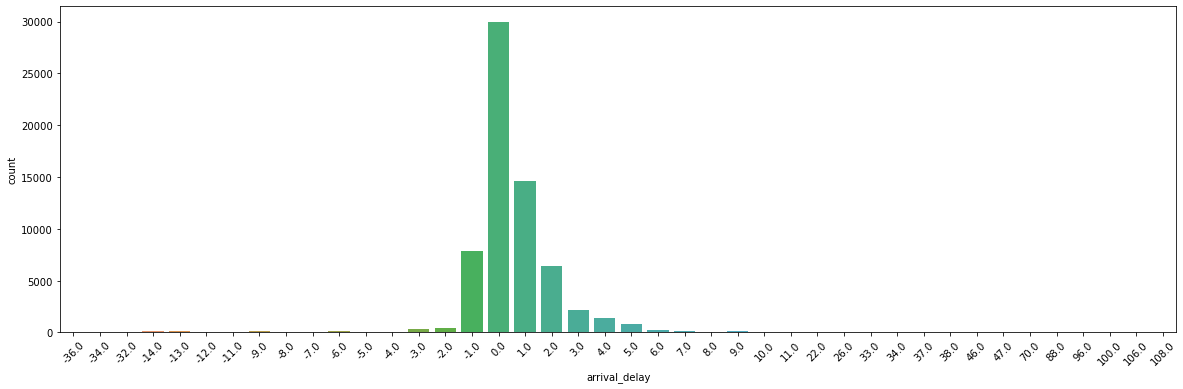

In [49]:
plot_delay_dist(sample_dist)

In [50]:
%%spark -o sample_dist
sample_dist = delays_distrib.filter(delays_distrib.STOP_NAME ==  "Schützenmattstrasse").filter(delays_distrib.produkt_id == "Tram")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

STATION : Schützenmattstrasse
MEAN OF TRANSPORTATION :  Tram


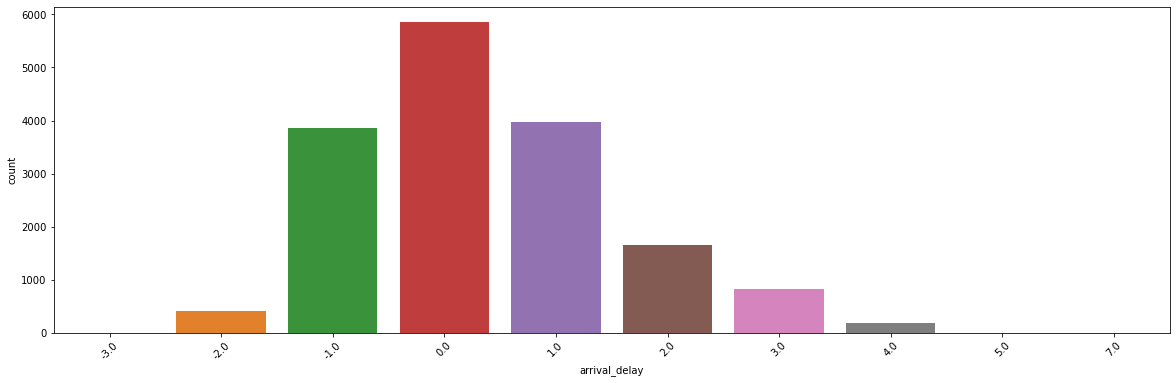

In [51]:
plot_delay_dist(sample_dist)

In [52]:
%%spark -o sample_dist
sample_dist = delays_distrib.filter(delays_distrib.STOP_NAME ==  "Schützenmattstrasse").filter(delays_distrib.produkt_id == "Bus")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

STATION : Schützenmattstrasse
MEAN OF TRANSPORTATION :  Bus


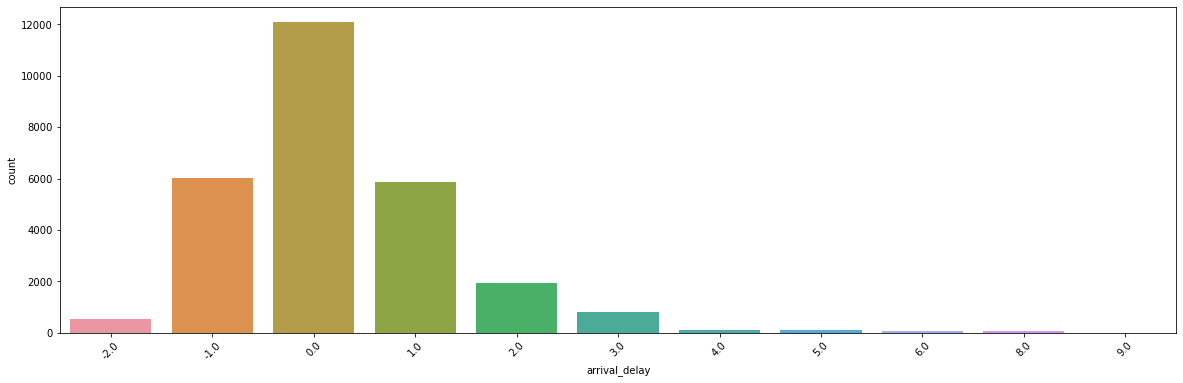

In [53]:
plot_delay_dist(sample_dist)

In [55]:
%%spark -o sample_dist
sample_dist = delays_distrib.filter(delays_distrib.STOP_NAME ==  "Studen BE").filter(delays_distrib.produkt_id == "Zug")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

STATION : Studen BE
MEAN OF TRANSPORTATION :  Zug


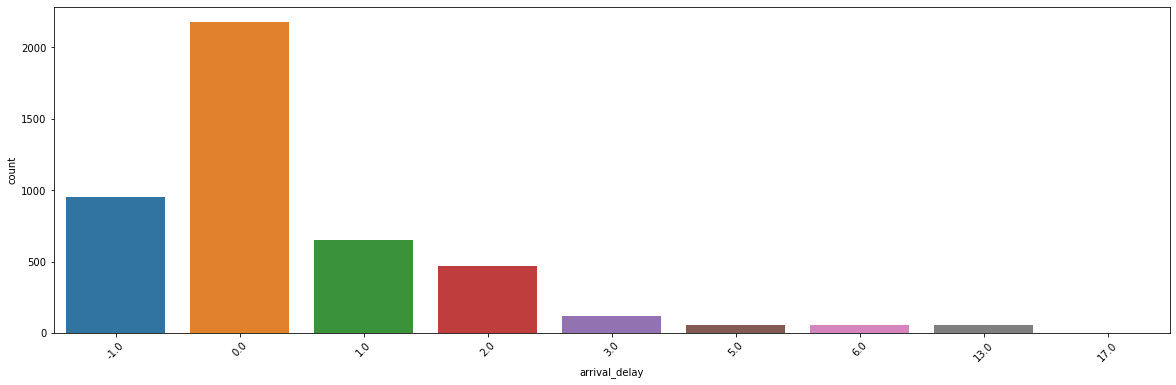

In [57]:
plot_delay_dist(sample_dist)

In [65]:
%%spark -o sample_dist
sample_dist = delays_distrib.filter(delays_distrib.STOP_NAME ==  "Zürich, Oerlikerhus").filter(delays_distrib.produkt_id == "Tram")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

STATION : Zürich, Oerlikerhus
MEAN OF TRANSPORTATION :  Tram


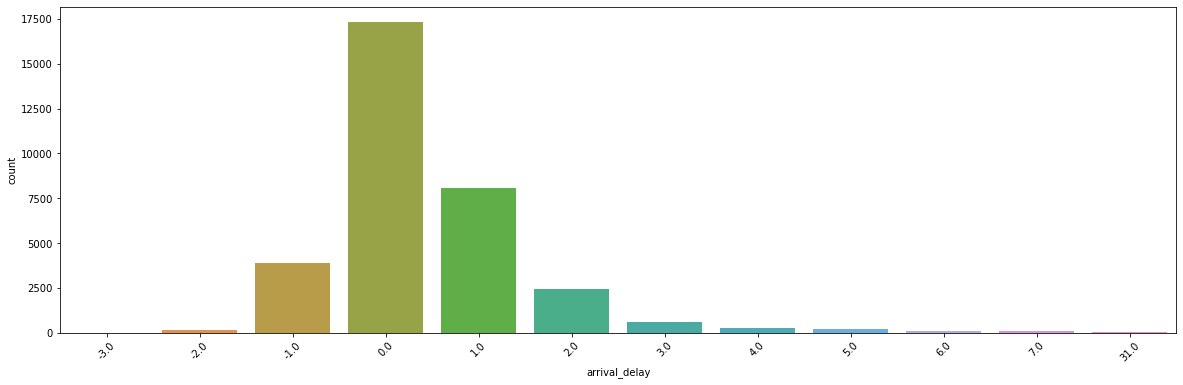

In [67]:
plot_delay_dist(sample_dist)

In [64]:
%%spark
#delays_distrib.filter(delays_distrib.STOP_NAME ==  "Studen BE").select("produkt_id").dropDuplicates().show()
delays_distrib.filter(delays_distrib.STOP_NAME == "Zürich, Oerlikerhus").select("produkt_id").dropDuplicates().show(30)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+
|produkt_id|
+----------+
|      Tram|
+----------+

In [160]:
%%spark -o full_dist
full_dist = delays_distrib.groupby("arrival_delay").sum()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [161]:
full_dist["arrival_delay"] = full_dist["arrival_delay"] / 60
full_dist = full_dist[full_dist.arrival_delay < 20]
full_dist = full_dist[full_dist.arrival_delay >= 0]

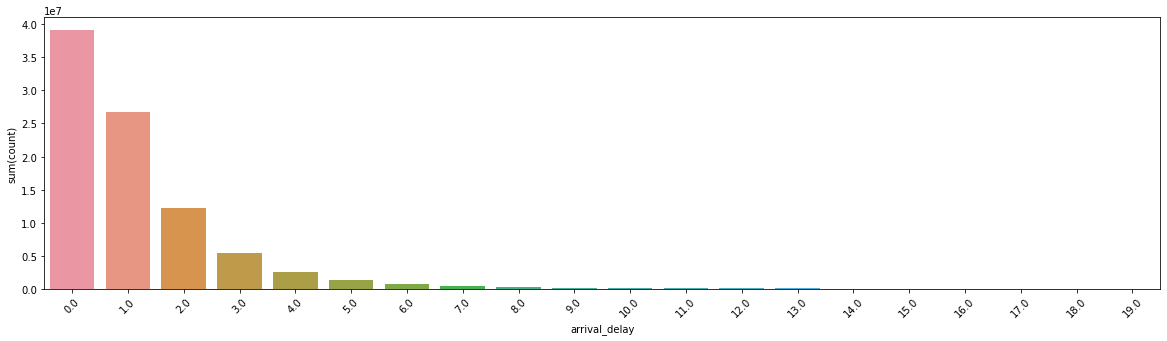

In [162]:
plt.subplots(figsize=(20, 5))
#full_count = full_dist["sum(count)"].sum()
#full_dist["y"] = full_dist["sum(count)"] / full_count
g = sns.barplot(data=full_dist.sort_values("arrival_delay"), x="arrival_delay", y="sum(count)")
g.set_xticklabels(g.get_xticklabels(), rotation=45);
#plt.xlim([-10, 10]);

### Get day of the `week` and `hour`

In [57]:
%%spark
real_time = real_time.filter("arrival_delay is not NULL")
real_time = real_time.withColumn("day_of_week", dayofweek(from_unixtime(col("arrival_time_schedule"))))
real_time = real_time.withColumn("hour", hour(from_unixtime(col("arrival_time_schedule"))))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Get mean delay table

In [58]:
%%spark
real_time = real_time.select(["STOP_NAME", "produkt_id", "arrival_delay", "day_of_week", "hour"]).dropna()
real_time = real_time.withColumn("arrival_delay", when(real_time["arrival_delay"] < 0, 0).when(col("arrival_delay").isNull(), 0).otherwise(col("arrival_delay")))
## creating the table
finalCols = ["STOP_NAME", "produkt_id", "day_of_week", "hour"]
real_time = real_time.groupBy(finalCols).mean()\
                     .select(finalCols + ["avg(arrival_delay)"])\
                     .dropDuplicates()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [59]:
%%spark
real_time = real_time.withColumnRenamed("avg(arrival_delay)", "inv_lambda")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
%%spark
real_time.coalesce(1).write.format("com.databricks.spark.csv")\
   .option("header", "true").save(REMOTE_PATH + "delay_distrib_final.csv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
%%spark
spark.read.orc("/data/sbb/part_orc/routes").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+---------+----------------+---------------+----------+----------+----+-----+---+
|      route_id|agency_id|route_short_name|route_long_name|route_desc|route_type|year|month|day|
+--------------+---------+----------------+---------------+----------+----------+----+-----+---+
|   10-25-j20-1|       11|              25|               |    S-Bahn|       400|2020|   10| 28|
|   10-27-j20-1|       82|              27|               |    S-Bahn|       400|2020|   10| 28|
|  10-501-j20-1|      801|             501|               |       Bus|       700|2020|   10| 28|
|  10-502-j20-1|      801|             502|               |       Bus|       700|2020|   10| 28|
|  10-503-j20-1|      801|             503|               |       Bus|       700|2020|   10| 28|
|  10-504-j20-1|      801|             504|               |       Bus|       700|2020|   10| 28|
|  10-511-j20-1|      801|             511|               |       Bus|       700|2020|   10| 28|
|  10-512-j20-1|      801|    

## Create Route Name table

In [61]:
%%spark

## creates route name !
route_names = spark.read.orc("/data/sbb/part_orc/routes").withColumn("route_name", concat(col("route_desc"), lit(" "), col("route_short_name")))\
                .select(["route_id", "route_name", "route_desc"])\
                .dropDuplicates()

## get simple type
complex_to_simple_type = {
    "TGV":"Train",
    "Eurocity":"Train",
    "Regionalzug":"Train",
    "RegioExpress":"Train",
    "S-Bahn":"Train",
    "Tram":"Tram",
    "ICE":"Train",
    "Bus":"Bus",
    "Eurostar":"Train",
    "Intercity":"Train",
    "InterRegio":"Train",
    "Extrazug":"Train"
}

get_simple_type = udf(lambda complex_type : complex_to_simple_type.get(complex_type,"unknown"))

route_names = route_names.withColumn("transport_type", get_simple_type(col("route_desc")))\
                .drop("route_desc")
route_names.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+----------+--------------+
|    route_id|route_name|transport_type|
+------------+----------+--------------+
| 12-81-j20-1|    Bus 81|           Bus|
|13-383-j20-1|   Bus 383|           Bus|
| 18-30-j20-1|    Bus 30|           Bus|
+------------+----------+--------------+
only showing top 3 rows

In [65]:
%%spark -o route_names_and_types -n -1
route_names_and_types = route_names
#route_names.coalesce(1).write.format("com.databricks.spark.csv")\
#   .option("header", "true").save(REMOTE_PATH + "route_names_and_types.csv")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
route_names_and_types

,route_id,route_name,transport_type
0,12-81-j20-1,Bus 81,Bus
1,13-383-j20-1,Bus 383,Bus
2,18-30-j20-1,Bus 30,Bus
3,19-N51-j20-1,Bus N51,Bus
4,20-NE2-j20-1,Bus NE2,Bus
...,...,...,...
25117,90-107-Y-j20-1,Fähre 107-Y,unknown
25118,90-179-Y-j18-1,Fähre 179-Y,unknown
25119,79-CAS-5-j20-1,Bus CAR13N,Bus
25120,79-732-B-j20-1,Taxi 7326,unknown


In [67]:
route_names_and_types.to_csv("../data/route_names_types.csv")